<h1> Soft Actor Critic Demystified</h1>
<h4> By Vaishak Kumar </h4>
<br>
<a href="https://arxiv.org/pdf/1801.01290.pdf">Original Paper</a>
<br> 
<a href="https://github.com/higgsfield/RL-Adventure-2">Adapted from higgsfield's implementation</a>

In [38]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h2>Auxilliary Functions</h2>

In [39]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
#         print(batch)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [56]:
class NormalizedActions(gym.ActionWrapper):
    def _action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        return action

    def _reverse_action(self, action):
        print(reverse_action)
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        return actions

In [57]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

<h1>Network Definitions</h1>

In [42]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

<h1> Update Function </h1>

In [66]:
def update(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)

    
    
# Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())


    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()    
# Training Value Function
    predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())

    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
# Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

<h2> Initializations </h2>

In [44]:
env = NormalizedActions(gym.make("Pendulum-v0"))

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
hidden_dim = 256

value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

# Training Hyperparameters

In [45]:
max_frames  = 40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 80

# Training Loop

In [ ]:
while frame_idx < max_frames:
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        if frame_idx >1000:
            action = policy_net.get_action(state).detach()
            next_state, reward, done, _ = env.step(action.numpy())
        else:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
        
        
        replay_buffer.push(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if len(replay_buffer) > batch_size:
            update(batch_size)
        
        if frame_idx % 1000 == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
        
    rewards.append(episode_reward)

  File "/Users/adrianow/Documents/Programs/anaconda2/envs/quadcop/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/adrianow/Documents/Programs/anaconda2/envs/quadcop/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/adrianow/Documents/Programs/anaconda2/envs/quadcop/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/adrianow/Documents/Programs/anaconda2/envs/quadcop/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/adrianow/Documents/Programs/anaconda2/envs/quadcop/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/Users/adrianow/Documents/Programs/anaconda2/envs/quadcop/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/Users/adrianow/Do

<h2> Visualize Trained Algorithm </h2> - <a href="http://mckinziebrandon.me/TensorflowNotebooks/2016/12/21/openai.html">source</a>  

In [10]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(anim)

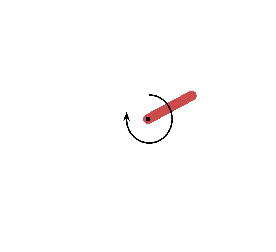

In [12]:
env = gym.make("Pendulum-v0")

# Run a demo of the environment
state = env.reset()
cum_reward = 0
frames = []
for t in range(50000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = policy_net.get_action(state)
    state, reward, done, info = env.step(action.detach())
    if done:
        break
env.close()
display_frames_as_gif(frames)



In [59]:
%load_ext autoreload
%autoreload 2

from task import Task

In [60]:
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos, init_pose=np.array([0.0, 0.0, 5.0, 0.0, 0.0, 0.0]))

action_dim = task.action_size
state_dim  = task.state_size
hidden_dim = 256

value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

In [136]:
max_frames  = 40000
max_episodes = 1000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 80
i_episode = 0
max_reward = 0
max_episode = 0

In [65]:
a = np.array([0, 300, 450, 600, 900])
normalize = lambda x: (x - task.action_high/2)/(task.action_high/2)
normalize(a)
denormalize = lambda x: x*task.action_high/2 + task.action_high/2
denormalize(normalize(a))

array([  0., 300., 450., 600., 900.])

In [132]:
task = Task(target_pos=target_pos, init_pose=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), runtime=10.)

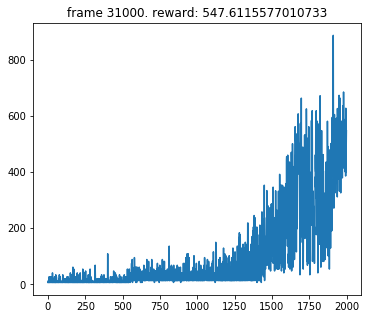

Episode = 31310, score = 426.779 (best = 3 - 529.276)

KeyboardInterrupt: 

In [142]:
i_episode = 0
best_exp = 0
max_reward = 0
while i_episode < max_episodes:
    state = task.reset()
    episode_reward = 0
    i_episode += 1
    episode_happenings = []
    
    for step in range(max_steps):
        if frame_idx >1000:
            action = denormalize(policy_net.get_action(state).detach())
            next_state, reward, done = task.step(action.numpy())    
        else:
            action = np.random.rand(4)*task.action_high
            next_state, reward, done = task.step(action)
        
        replay_buffer.push(state, normalize(action), reward, next_state, done)
        
        episode_happening = [i_episode, reward] + [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action)
        episode_happenings.append(episode_happening)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if len(replay_buffer) > batch_size:
            update(batch_size)
            
        if frame_idx % 1000 == 0:
            plot(frame_idx, rewards)
        
        if done:
            max_reward = max(max_reward, episode_reward)
            max_episode = i_episode if (max_reward == episode_reward) else max_episode
            best_exp = episode_happenings if (max_reward == episode_reward) else best_exp
            break
    
    rewards.append(episode_reward)
    print("\rEpisode = {:4d}, score = {:7.3f} (best = {} - {:7.3f})".format(
            frame_idx, episode_reward, max_episode , max_reward), end="") 
    

In [174]:
%load_ext autoreload
%autoreload 2

from agents.sac import SACAgent
import os
import 

task = Task(target_pos=target_pos, init_pose=np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), runtime=10.)
sac = SACAgent(task, target_pos)

sac.value_net = value_net
sac.soft_q_net1 = soft_q_net1
sac.soft_q_net2 = soft_q_net2
sac.policy_net = policy_net

sac.save_models(os.path.join(os.getcwd(), 'models'))
sac.load_models(os.path.join(os.getcwd(), 'models'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Models saved to /Users/adrianow/Documents/Udacity/ND/MLND/v2.0/RL-Quadcopter-2/models
Models loaded from /Users/adrianow/Documents/Udacity/ND/MLND/v2.0/RL-Quadcopter-2/models


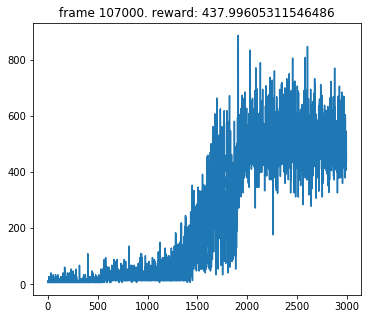

Episode = 107505, score = 478.792 (best = 602 - 848.072)

In [175]:
i_episode = 0
best_exp = 0
max_reward = 0
while i_episode < max_episodes:
    state = task.reset()
    episode_reward = 0
    i_episode += 1
    episode_happenings = []
    
    for step in range(max_steps):
        if frame_idx >1000:
            action = sac.get_actions(state)
            next_state, reward, done = task.step(action.numpy())    
        else:
            action = np.random.rand(4)*task.action_high
            next_state, reward, done = task.step(action)
        
        sac.save_experience(state, action, reward, next_state, done)
        
        episode_happening = [i_episode, reward] + [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action)
        episode_happenings.append(episode_happening)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        sac.learn(batch_size)
            
        if frame_idx % 1000 == 0:
            plot(frame_idx, rewards)
        
        if done:
            max_reward = max(max_reward, episode_reward)
            max_episode = i_episode if (max_reward == episode_reward) else max_episode
            best_exp = episode_happenings if (max_reward == episode_reward) else best_exp
            break
    
    rewards.append(episode_reward)
    print("\rEpisode = {:4d}, score = {:7.3f} (best = {} - {:7.3f})".format(
            frame_idx, episode_reward, max_episode , max_reward), end="") 

In [96]:
# execute 
state = task.reset()
episode_reward = 0
done = False
episode_happenings = []

while True:
    action = denormalize(policy_net.get_action(state).detach())
    next_state, reward, done = task.step(action.numpy())  
    
    episode_happening = [i_episode, reward] + [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(action)
    episode_happenings.append(episode_happening)

    state = next_state
    episode_reward += reward

    if done:
        print('Episode finished with reward {}'.format(episode_reward))
        break

Episode finished with reward 568.2654639456756


In [123]:
labels = ['episode_i', 'reward', 'time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
df = pd.DataFrame(episode_happenings, columns=labels)
df

episode_i    reward  time         x             y          z       phi  \
0          86  6.835283  0.06 -0.000006  4.199693e-08   5.025438  0.000025   
1          86  6.835513  0.12 -0.000136  2.771046e-06   5.102463  0.000430   
2          86  6.835941  0.18 -0.000675  3.698337e-05   5.230208  0.001400   
3          86  6.836557  0.24 -0.001987  1.765993e-04   5.407515  0.002451   
4          86  6.837361  0.30 -0.004531  5.098911e-04   5.634485  0.003719   
5          86  6.838345  0.36 -0.008826  1.137526e-03   5.910036  0.005280   
6          86  6.839499  0.42 -0.015395  2.170891e-03   6.231289  0.007007   
7          86  6.840810  0.48 -0.024789  3.740301e-03   6.596866  0.009002   
8          86  6.842278  0.54 -0.037521  6.014720e-03   7.007821  0.012845   
9          86  6.843896  0.60 -0.053918  9.246766e-03   7.462232  0.018397   
10         86  6.845646  0.66 -0.074126  1.377123e-02   7.955568  0.024111   
11         86  6.847492  0.72 -0.097701  1.967169e-02   8.474028  0.029716   
12         86  6.849397  0.78 -0.124963  2.733174e-02   9.017579  0.034915   
13         86  6.851382  0.84 -0.155392  3.699834e-02   9.585424  0.039009   
14         86  6.852984  0.90 -0.187895  4.847199e-02  10.165181  0.043087   
15         86  6.851200  0.96 -0.221936  6.236754e-02  10.766445  0.046953   
16         86  6.848652  1.02 -0.254769  7.934589e-02  11.398997  0.049773   
17         86  6.845985  1.08 -0.282721  9.967960e-02  12.060206  0.079438   
18         86  6.843230  1.14 -0.302242  1.244548e-01  12.743220  0.128734   
19         86  6.840417  1.20 -0.309702  1.554267e-01  13.443341  0.123163   
20         86  6.837576  1.26 -0.304100  1.917452e-01  14.151341  0.068094   
21         86  6.834784  1.32 -0.295293  2.296108e-01  14.837340  6.214178   
22         86  6.832090  1.38 -0.272748  2.640843e-01  15.516762  6.049745   
23         86  6.829463  1.44 -0.234715  2.929945e-01  16.193757  6.157640   
24         86  6.826950  1.50 -0.201337  3.217559e-01  16.833421  5.925701   
25         86  6.824561  1.56 -0.164946  3.458418e-01  17.446311  5.930334   
26         86  6.822246  1.62 -0.140067  3.653314e-01  18.044753  0.853831   
27         86  6.819917  1.68 -0.141742  3.895855e-01  18.607280  1.542203   
28         86  6.817687  1.74 -0.153433  4.059014e-01  19.139034  1.883596   
29         86  6.815532  1.80 -0.180975  4.098478e-01  19.649133  3.402253   
30         86  6.813571  1.86 -0.175447  3.965806e-01  20.133159  6.247811   
31         86  6.811892  1.92 -0.161117  3.636122e-01  20.591023  0.824431   
32         86  6.810308  1.98 -0.155879  3.314008e-01  21.018836  2.132722   
33         86  6.808798  2.04 -0.166921  2.990567e-01  21.414297  2.781233   
34         86  6.807329  2.10 -0.222318  2.702522e-01  21.755790  4.516939   
35         86  6.805877  2.16 -0.333498  2.326703e-01  22.049488  0.437078   
36         86  6.804269  2.22 -0.542902  2.007420e-01  22.319915  1.384074   

       theta  psi  x_velocity  y_velocity  z_velocity  phi_velocity  \
0   0.001705  0.0   -0.000449    0.000004    0.847720      0.001249   
1   0.005370  0.0   -0.004657    0.000142    1.718897      0.015933   
2   0.009822  0.0   -0.014188    0.001198    2.537823      0.016651   
3   0.015410  0.0   -0.030663    0.003668    3.370358      0.019198   
4   0.021986  0.0   -0.055418    0.007687    4.192651      0.024721   
5   0.029327  0.0   -0.089173    0.013533    4.989217      0.028501   
6   0.036702  0.0   -0.131192    0.021227    5.715841      0.029335   
7   0.042271  0.0   -0.182903    0.031431    6.466080      0.040110   
8   0.047374  0.0   -0.242334    0.045005    7.227875      0.090644   
9   0.052121  0.0   -0.304927    0.063701    7.914626      0.096051   
10  0.055571  0.0   -0.369151    0.088044    8.525463      0.093524   
11  0.063614  0.0   -0.417866    0.109269    8.754713      0.093226   
12  0.048448  0.0   -0.487928    0.146881    9.359015      0.068323   
13  0.041584  0.0   -0.525843    0.175759    

In [139]:
import pandas as pd
labels = ['episode_i', 'reward', 'time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
df = pd.DataFrame(best_exp, columns=labels)
df

episode_i    reward  time          x          y          z       phi  \
0          912  6.815820  0.06  -0.000033   0.000004   0.069421  0.000692   
1          912  6.816458  0.12  -0.000593   0.000110   0.277276  0.002492   
2          912  6.817630  0.18  -0.002874   0.000594   0.620909  0.005263   
3          912  6.819311  0.24  -0.009057   0.001879   1.096107  0.009136   
4          912  6.821465  0.30  -0.021977   0.004531   1.697560  0.013164   
5          912  6.824049  0.36  -0.044552   0.009101   2.417327  0.018267   
6          912  6.827009  0.42  -0.080283   0.016179   3.246312  0.024847   
7          912  6.830283  0.48  -0.133212   0.026411   4.172377  0.036234   
8          912  6.833791  0.54  -0.208642   0.040734   5.182852  0.054152   
9          912  6.837406  0.60  -0.300448   0.058123   6.224945  0.074761   
10         912  6.840983  0.66  -0.413750   0.080666   7.292962  0.167533   
11         912  6.844573  0.72  -0.560554   0.115852   8.411434  0.374470   
12         912  6.848081  0.78  -0.745385   0.171590   9.563016  0.485676   
13         912  6.848751  0.84  -0.960293   0.244781  10.726504  0.598691   
14         912  6.843307  0.90  -1.191780   0.328873  11.884792  0.727977   
15         912  6.837593  0.96  -1.440799   0.433598  13.047347  0.856308   
16         912  6.831587  1.02  -1.715831   0.577918  14.228684  0.982063   
17         912  6.825137  1.08  -2.026898   0.780749  15.436581  1.108640   
18         912  6.818092  1.14  -2.388242   1.066374  16.675882  1.241169   
19         912  6.810558  1.20  -2.771349   1.387467  17.923652  1.375426   
20         912  6.803010  1.26  -3.162232   1.703287  19.164299  1.515353   
21         912  6.795396  1.32  -3.569129   2.008262  20.402304  1.656435   
22         912  6.787775  1.38  -3.999475   2.282255  21.643217  1.799297   
23         912  6.780097  1.44  -4.458147   2.533480  22.889252  1.944005   
24         912  6.772266  1.50  -4.964275   2.782844  24.138178  2.253534   
25         912  6.764077  1.56  -5.563163   3.057252  25.361659  2.979680   
26         912  6.755704  1.62  -6.226184   3.345175  26.508420  5.161993   
27         912  6.747584  1.68  -6.904007   3.601364  27.585776  4.908948   
28         912  6.739708  1.74  -7.590650   3.849557  28.603015  4.664482   
29         912  6.731982  1.80  -8.295046   4.105835  29.563321  4.432764   
..         ...       ...   ...        ...        ...        ...       ...   
106        912  6.348406  6.42 -50.270583  41.500794  39.880480  5.094287   
107        912  6.348238  6.48 -50.630525  42.172772  38.799082  0.763495   
108        912  6.348223  6.54 -50.974309  42.844437  37.714210  6.235392   
109        912  6.348152  6.60 -51.333305  43.505869  36.622176  5.791528   
110        912  6.348173  6.66 -51.676008  44.155560  35.523859  5.780826   
111        912  6.348301  6.72 -52.027661  44.814239  34.375636  4.950309   
112        912  6.348453  6.78 -52.448352  45.446072  33.188929  0.347961   
113        912  6.348365  6.84 -52.944278  46.055861  31.973780  5.745245   
114        912  6.348410  6.90 -53.417104  46.649340  30.742690  0.554205   
115        912  6.348726  6.96 -53.870404  47.221356  29.481543  6.192808   
116        912  6.349227  7.02 -54.346070  47.782815  28.163819  5.760764   
117        912  6.349820  7.08 -54.830114  48.343805  26.796201  4.856484   
118        912  6.350815  7.14 -55.272974  48.871771  25.371788  4.448162   
119        912  6.352094  7.20 -55.766087  49.393355  23.878440  3.370134   
120        912  6.353198  7.26 -56.266288  49.954104  22.340788  2.280434   
121        912  6.354471  7.32 -56.732158  50.557311  20.733739  1.819627   
122        912  6.355608  7.38 -57.228041  51.195852  19.111147  1.913313   
123        912  6.356432  7.44 -57.773310  51.797849  17.506103  1.071962   
124        912  6.357423  7.50 -58.291286  52.344807  15.913848  0.305449   
125        912  6.358550  7.56 -58.810069  52.875151  14.334370  0.642638   
1

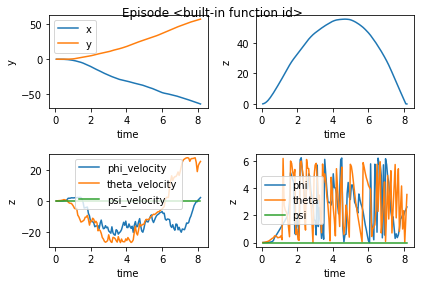

In [140]:
# df = pd.read_csv('best_episodes.csv')
# id = 164
# id = id or df['episode_i'].max()
xyztime = df

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)
fig.suptitle('Episode {}'.format(id))

axs[0,0].plot(xyztime.time, xyztime.x)
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('x')

axs[0,0].plot(xyztime.time, xyztime.y)
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('y')

axs[0,0].legend()

axs[0, 1].plot(xyztime.time, xyztime.z)
axs[0, 1].set_xlabel('time')
axs[0, 1].set_ylabel('z')


axs[1, 0].plot(xyztime.time, xyztime.phi_velocity)
axs[1, 0].plot(xyztime.time, xyztime.theta_velocity)
axs[1, 0].plot(xyztime.time, xyztime.psi_velocity)
axs[1, 0].set_xlabel('time')
axs[1, 0].set_ylabel('z')
axs[1, 0].legend()


axs[1, 1].plot(xyztime.time, xyztime.phi)
axs[1, 1].plot(xyztime.time, xyztime.theta)
axs[1, 1].plot(xyztime.time, xyztime.psi)
axs[1, 1].set_xlabel('time')
axs[1, 1].set_ylabel('z')
axs[1,1].legend()

fig.tight_layout()

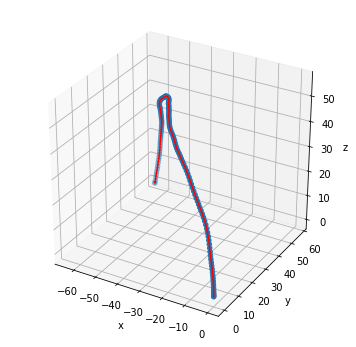

In [141]:
from mpl_toolkits import mplot3d

import matplotlib.pyplot as plt
%matplotlib inline
X = xyztime.x
Y = xyztime.y
Z = xyztime.z 
fig3D = plt.figure(figsize=(6,6))
ax3D = plt.axes(projection='3d')
ax3D.scatter3D(X,Y,Z)
ax3D.plot(X,Y,Z, color='r')
ax3D.set_xlabel('x')
ax3D.set_ylabel('y')
ax3D.set_zlabel('z')
plt.show()